In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rdkit import Chem
import numpy as np
import os
import sys
sys.path.append('../')
sys.path.append('../data_processing/')
sys.path.append('../model/')

from openbabel import pybel
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import torch

from torch_geometric.data import download_url, extract_zip

In [4]:
from data_processing.ligand import Ligand

In [5]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

# Cross docked dataset

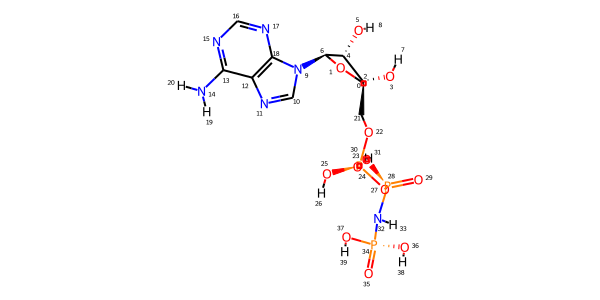

In [6]:
path = '../../data/small_dataset/raw/ZAP70_HUMAN_327_607_0/2ozo_A_rec_2ozo_anp_lig_tt_docked_2.sdf'
rdmol = Chem.MolFromMolFile(path, sanitize=False)
rdmol

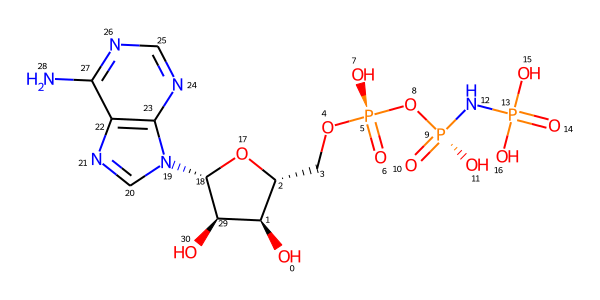

In [7]:
mol = Chem.MolFromSmiles(Chem.MolToSmiles(rdmol))
mol

In [8]:
# rdmol = Chem.RemoveHs(rdmol)

In [9]:
smi = Chem.MolToSmiles(mol)
smi

'Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[P@](=O)(O)O[P@@](=O)(O)NP(=O)(O)O)[C@@H](O)[C@H]1O'

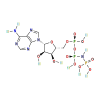

In [10]:
pbmol = next(pybel.readfile("sdf", path))
# pbmol = pybel.readstring('smi', smi)
# pbmol = pybel.readfile("sdf", path)
pbmol

## Check the number of atom of open babel and rdkit mol
- RemoveHs() does not remove H atoms that have wedged bonds to them in case they are involved in setting stereochemistry. According to https://github.com/rdkit/rdkit/issues/2422
- Solution: https://github.com/rdkit/rdkit/discussions/6613

In [11]:
pbmol.removeh()
obmol = pbmol.OBMol
obatoms = [obmol.GetAtom(i + 1) for i in range(obmol.NumAtoms())]
len(obatoms)

31

In [12]:
[a.GetType() for a in obatoms]

['C3',
 'O3',
 'C3',
 'O3',
 'C3',
 'O3',
 'C3',
 'Nar',
 'Car',
 'Nar',
 'Car',
 'Car',
 'Npl',
 'Nar',
 'Car',
 'Nar',
 'Car',
 'C3',
 'O3',
 'P',
 'O2',
 'O3',
 'O3',
 'P',
 'O2',
 'O3',
 'N3',
 'Pac',
 'O2',
 'O3',
 'O3']

In [13]:
for a in rdmol.GetAtoms():
    if a.GetNumImplicitHs():
        a.SetNumRadicalElectrons(a.GetNumImplicitHs())
        a.SetNoImplicit(True)
        a.UpdatePropertyCache()
molRemoveAllHs = Chem.RemoveAllHs(rdmol)

In [14]:
# rdmol = Chem.RemoveHs(rdmol)
print(rdmol.GetNumAtoms())
molRemoveAllHs.GetNumAtoms()

40


31

In [15]:
mol = Chem.RemoveHs(mol)
mol.GetNumAtoms()

31

In [16]:
[a.GetSymbol() for a in rdmol.GetAtoms()]

['C',
 'O',
 'C',
 'O',
 'C',
 'O',
 'C',
 'H',
 'H',
 'N',
 'C',
 'N',
 'C',
 'C',
 'N',
 'N',
 'C',
 'N',
 'C',
 'H',
 'H',
 'C',
 'O',
 'P',
 'O',
 'O',
 'H',
 'O',
 'P',
 'O',
 'O',
 'H',
 'N',
 'H',
 'P',
 'O',
 'O',
 'O',
 'H',
 'H']

In [17]:
mol.GetNumAtoms()

31

# Construct pharmacophore graphs

In [18]:
ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None)
# len(ligand.graph.node_clusters)
len(ligand.pharmacophore_list)

AssertionError: Atom Number ERROR - openbabel: 31, rdkit: 40

In [ ]:
len(ligand.graph.nodes)

In [19]:
# the graph is fully connected
for edge in ligand.graph.edges:
    print(edge.indices)

NameError: name 'ligand' is not defined

In [ ]:
def construct_pp_graph(rdmol, ligand):
    for pp in ligand.pharmacophore_list:
        

# pytorch-geometric dataset

In [23]:
import glob, os
import pickle

In [7]:
with open('../../data/cleaned_crossdocked_data/index.pkl', 'rb') as f:
    index = pickle.load(f)
index

[('1B57_HUMAN_25_300_0/3vrj_A_rec.pdb',
  '1B57_HUMAN_25_300_0/3vrj_A_rec_5u98_1kx_lig_tt_min_0.sdf',
  0.6701),
 ('1B57_HUMAN_25_300_0/5u98_D_rec.pdb',
  '1B57_HUMAN_25_300_0/5u98_D_rec_5u98_1kx_lig_tt_min_0.sdf',
  0.3669),
 ('1B57_HUMAN_25_300_0/3upr_C_rec.pdb',
  '1B57_HUMAN_25_300_0/3upr_C_rec_5u98_1kx_lig_tt_min_0.sdf',
  0.4004),
 ('1B57_HUMAN_25_300_0/3vri_A_rec.pdb',
  '1B57_HUMAN_25_300_0/3vri_A_rec_5u98_1kx_lig_tt_docked_0.sdf',
  0.5267),
 ('1B57_HUMAN_25_300_0/3vri_A_rec.pdb',
  '1B57_HUMAN_25_300_0/3vri_A_rec_5u98_1kx_lig_tt_min_0.sdf',
  0.5178),
 ('1B57_HUMAN_25_300_0/3vrj_A_rec.pdb',
  '1B57_HUMAN_25_300_0/3vrj_A_rec_3upr_1kx_lig_tt_min_0.sdf',
  0.7476),
 ('1B57_HUMAN_25_300_0/5u98_D_rec.pdb',
  '1B57_HUMAN_25_300_0/5u98_D_rec_3upr_1kx_lig_tt_min_0.sdf',
  0.4364),
 ('1B57_HUMAN_25_300_0/3upr_C_rec.pdb',
  '1B57_HUMAN_25_300_0/3upr_C_rec_3upr_1kx_lig_tt_min_0.sdf',
  0.3355),
 ('1B57_HUMAN_25_300_0/3vri_A_rec.pdb',
  '1B57_HUMAN_25_300_0/3vri_A_rec_3upr_1kx_lig_tt_min

In [10]:
docked_pdb = os.listdir('../../data/cleaned_crossdocked_data')
len(docked_pdb)

2402

In [24]:
def list_sdf_files(root):
    return glob.glob(root+'*/*.sdf')

In [29]:
small_dataset = list_sdf_files('../../data/small_dataset/raw/')
len(small_dataset)

16

In [45]:
for filename in small_dataset:
    rdmol = Chem.MolFromMolFile(filename, sanitize=False)
    conformer = rdmol.GetConformer()
    atom_positions = conformer.GetPositions()
    print(filename)
    print(atom_positions)

../../data/small_dataset/ZIPA_ECOLI_187_328_0/1s1s_B_rec_1y2g_cl3_lig_tt_min_0.sdf
[[26.5949 14.1818  4.0963]
 [25.8784 14.1196  5.1629]
 [26.2695 14.5339  6.3947]
 [27.6289 15.1265  6.5607]
 [28.4162 15.213   5.4395]
 [27.8834 14.7143  4.0934]
 [24.6199 13.6413  5.3619]
 [24.3282 13.8075  6.6795]
 [25.2947 14.3268  7.2771]
 [28.6766 14.7816  2.8314]
 [28.5015 13.7871  1.819 ]
 [29.2627 13.8358  0.619 ]
 [30.2029 14.8724  0.4217]
 [30.383  15.8674  1.4115]
 [29.6278 15.8241  2.6025]
 [23.6609 13.0473  4.3924]
 [24.1554 12.556   3.1603]
 [23.287  11.9841  2.1879]
 [21.9    11.9027  2.4667]
 [21.3892 12.3792  3.6869]
 [22.2613 12.9505  4.6468]
 [25.3756 12.7799 -0.086 ]
 [23.8125 11.5281  1.0092]
 [22.953  10.7278  0.1139]
 [25.0791 11.7582  0.5368]
 [26.1718 10.708   0.7884]]
../../data/small_dataset/ZIPA_ECOLI_187_328_0/1y2f_A_rec_1y2g_cl3_lig_tt_min_0.sdf
[[2.67215e+01 1.45483e+01 4.23880e+00]
 [2.61342e+01 1.46574e+01 5.37800e+00]
 [2.66982e+01 1.51617e+01 6.50540e+00]
 [2.81083e+01 

In [14]:
from data_processing.paired_data import PharmacophoreDataset, CombinedSparseGraphDataset
# dataset = CombinedSparseGraphDataset(root='../../data/small_dataset', split='all')
dataset = CombinedSparseGraphDataset(root='../../data/cleaned_crossdocked_data', split='valid')

In [11]:
len(dataset)

21729

In [12]:
dataset[0]

Data(x=[42, 8], pos=[42, 3], target_x=[42, 8], target_pos=[42, 3], Gt_mask=[42], ligand_name='3zxw_A_rec_3zxw_cap_lig_tt_min_0')

In [13]:
dataset[0].x, dataset[0].pos

(tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0

In [12]:
dataset[0].target_x

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0

In [13]:
len(dataset)

65

In [9]:
name = []
for i in range(len(dataset)):
    
#     print(dataset[i])
#     print(dataset[i].ligand_name)
    name.append(dataset[i].ligand_name)

In [14]:
# all_names = [file.split('/')[-1].split('.')[0] for file in dataset]
# all_names

In [15]:
# missing = [i for i in all_names if i not in name]
# missing

In [16]:
from torch_geometric.loader import DataLoader, DenseDataLoader
from torch_geometric.utils import to_dense_batch
from data_processing.utils import make_edge_mask

In [17]:
data_loader = DataLoader(dataset, batch_size=5, shuffle=False, num_workers=24)
one = next(iter(data_loader))

In [19]:
one

DataBatch(x=[216, 12], pos=[216, 3], target_x=[216, 12], target_pos=[216, 3], Gt_mask=[216], ligand_name=[5], batch=[216], ptr=[6])

In [21]:
print(one.x)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [13]:
# one.node_mask * one.x

batch_size = one.x.size(0)
N = one.batch.size(0)
max_N = 86
x = one.x.view(batch_size*max_N, -1)
node_mask = one.node_mask.view(batch_size*max_N, -1)
sparse_x = x*node_mask
sparse_x.size()

torch.Size([430, 13])

In [151]:
batch = one.batch
dense_batch, batch_mask = to_dense_batch(batch, max_num_nodes=max_N*batch_size, fill_value=batch_size)
dense_batch = dense_batch[0]
print(batch.size(), dense_batch.size())

torch.Size([166]) torch.Size([430])


In [152]:
dense_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [225]:
new_x_ctr = torch.zeros([batch_size, 2*max_N, x.size(-1)])
new_node_mask_ctr = torch.zeros([batch_size, 2*max_N]).bool()
node_mask_Gt = torch.zeros([batch_size, 2*max_N]).bool()
new_edge_mask_list = []
for i in range(batch_size):
    n_node = one.node_mask[i].sum()
    new_x_ctr[i, :n_node, ] = one.x[i, :n_node, ]
    new_x_ctr[i, n_node:2*n_node, ] = one.target_x[i, :n_node, ]
    new_node_mask_ctr[i, :2*n_node] = True
    node_mask_Gt[i, :n_node] = True
    edge_mask = make_edge_mask(2*n_node, 2*max_N)
    new_edge_mask_list.append(edge_mask)
    
    print(n_node)
    
# new_edge_mask_ctr = torch.tensor(np.array(new_edge_mask_list))
new_edge_mask_ctr = torch.cat(new_edge_mask_list, dim=0)

tensor(40)
tensor(37)
tensor(37)
tensor(26)
tensor(26)


In [226]:
new_x_ctr.size()

torch.Size([5, 172, 13])

In [227]:
for mask in new_node_mask_ctr:
    print(mask.sum())

tensor(80)
tensor(74)
tensor(74)
tensor(52)
tensor(52)


In [228]:
for mask in node_mask_Gt:
    print(mask.sum())

tensor(40)
tensor(37)
tensor(37)
tensor(26)
tensor(26)


In [229]:
new_edge_mask_ctr.size()

torch.Size([5, 29584])

In [223]:
batch_mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

In [154]:
one.ligand_name

['2ozo_A_rec_2ozo_anp_lig_tt_docked_2',
 '1u59_A_rec_1u59_stu_lig_tt_docked_0',
 '1u59_A_rec_1u59_stu_lig_tt_min_0',
 '1s1s_B_rec_1y2g_cl3_lig_tt_min_0',
 '1y2f_A_rec_1y2g_cl3_lig_tt_min_0']

In [155]:
# nodes' membership in each graph
one.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [156]:
# starting node idx in each graph
one.ptr

tensor([  0,  40,  77, 114, 140, 166])

In [166]:
from model.utils.utils_EGNN import compose_graph

In [167]:
x, pos, mask = compose_graph(one.x, one.target_x, one.pos, one.target_pos, one.node_mask, one.edge_mask, one.batch)

In [168]:
mask.size()

torch.Size([5, 172])

In [169]:
mask

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [170]:
for m in mask:
    print(sum(m))

tensor(49)
tensor(34)
tensor(63)
tensor(20)
tensor(0)


In [171]:
one.ptr

tensor([  0,  40,  77, 114, 140, 166])

In [14]:
dataset[13]

Data(x=[33, 8], pos=[33, 3], target_x=[33, 8], target_pos=[33, 3])

In [17]:
def load_data(dataset):
    data_loader = DataLoader(dataset, batch_size=20, shuffle=True)
    while True:
        yield from data_loader

In [22]:
data = load_data(dataset)
data

<generator object load_data at 0x7fa19512cc10>

In [23]:
for x, pos, target_x, target_pos, _, _ in data:
    print(x)

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

('x', tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]))
('x', tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]

KeyboardInterrupt: 

In [6]:
from data_processing.paired_data import PharmacophoreDataset

In [7]:
train_dataset = PharmacophoreDataset(root='../../data/cleaned_crossdocked_data', split='train')
valid_dataset = PharmacophoreDataset(root='../../data/cleaned_crossdocked_data', split='valid')
test_dataset = PharmacophoreDataset(root='../../data/cleaned_crossdocked_data', split='test')

In [9]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(11941, 1099, 1940)

# Error occurs for CCPR_YEAST_69_361_0 ligand
- The ligand pdb id is 3mt
- reason: ligand is too small to have any pharmacophores

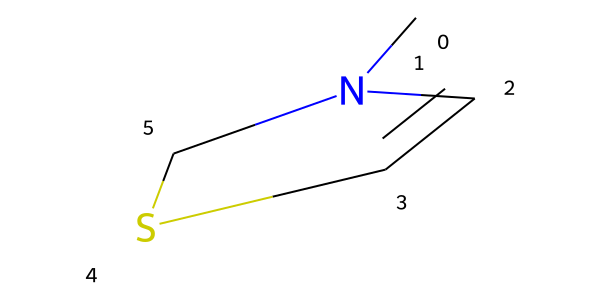

In [12]:
path = '../../data/small_dataset/raw/CCPR_YEAST_69_361_0/1aee_A_rec_1aeb_3mt_lig_tt_min_0.sdf'
rdmol = Chem.MolFromMolFile(path, sanitize=False)
rdmol

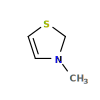

In [13]:
pbmol = next(pybel.readfile("sdf", path))
pbmol

In [14]:
ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None)

In [15]:
all_pp = []
for i, (pp_type, pp_node) in enumerate(ligand.pharmacophore_list):
    atom_indices = tuple([pp_node.atom_indices]) if type(pp_node.atom_indices)==int else tuple(sorted(pp_node.atom_indices))
#     print(pp_type, atom_indices)
    all_pp.append([pp_type, atom_indices, i])
    

all_pp

[]

# QM9 dataset

In [8]:
url = 'https://data.pyg.org/datasets/qm9_v3.zip'
raw_dir = '../../data/qm9/raw'
path = download_url(url, raw_dir)

In [11]:
extract_zip(path, raw_dir)
os.unlink(path)

Extracting ../../data/qm9/raw/qm9_v3.zip


In [19]:
# raw_paths = os.listdir(raw_dir)
raw_paths = ['../../data/qm9/raw/gdb9.sdf']
raw_paths

['../../data/qm9/raw/gdb9.sdf']

In [20]:
suppl = Chem.SDMolSupplier(raw_paths[0], removeHs=False)
len(suppl)

133885

In [35]:
pb_reader = pybel.readfile("sdf", raw_paths[0])

In [31]:
pbmols = [mol for mol in pb_reader]
len(pbmols)

133885

In [36]:
pbmols = list(pb_reader)
len(pbmols)

133885

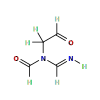

In [41]:
pbmols[10000]

In [43]:
from data_processing.qm9_data import QM9Dataset

In [44]:
qm9 = QM9Dataset('../../data/qm9', split='all')
len(qm9)

129428

In [49]:
one = qm9[50000]
one

Data(x=[32, 8], pos=[32, 3], target_x=[32, 8], target_pos=[32, 3], Gt_mask=[32], ligand_name='[H]C(=O)O[C@]1([H])C([H])([H])C(=O)N([H])C1([H])[H]')

In [53]:
one.Gt_mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [56]:
one.target_x[one.Gt_mask]

tensor([[0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]])

In [57]:
one.x[one.Gt_mask]

tensor([[0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]])

In [58]:
one.x[~one.Gt_mask]

tensor([[0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.]])